# Fairness definitions / Parity constraints
Generally speaking, the goal of the type of fairness that fairlearn implements is to avoid harm. There are various ways to implement this. The fairlearn package distinguishes and implements the following fairness constraints for group fairness:

# Binary classification:
DP - Demographic Parity: “the percentage of samples with label 1 should be equal across all groups”
Note that this concerns the predicted label, not the true label.

TPRP - True positive rate parity: sensitive features should not affect the true positive rate

FPRP - False positive rate parity: sensitive features should not affect the false positive rate

EO - Equalized odds: “satisfies both true positive rate parity and false positive rate parity”(https://deepnote.com/@Machine-Learning-2/Miniproject-cf9db77c-6a96-492b-bb41-5df89ffbbb38)


ERP - Error Rate Parity: “error rates should be the same across all groups”, which again is another way of saying that sensitive features should not affect error rates

Fairlearn includes various possible relaxations for these constraints, as exact parity is often unrealistic.

# Regression:
BGL - Bounded Group Loss: the expected (regression) loss of each group must be below a chosen threshold

# For binary classification, two main definition of fairness exist:

# Demographic parity 
(also known as statistical parity): A classifier h satisfies demographic parity under a distribution over (X,A,Y) if its prediction h(X) is statistically independent of the sensitive feature A. This is equivalent to:

#                        𝐸[ℎ(𝑋)|𝐴=𝑎]=𝐸[ℎ(𝑋)]E[h(X)|A=a]=E[h(X)]

# Equalized odds:
A classifier h satisfies equalized odds under a distribution over (X,A,Y) if its prediction h(X) is conditionally independent of the sensitive feature A given the label Y. This is equivalent to:
                
#                       𝐸[ℎ(𝑋)|𝐴=𝑎,𝑌=𝑦]=𝐸[ℎ(𝑋)|𝑌=𝑦]E[h(X)|A=a,Y=y]=E[h(X)|Y=y]

Demographic Parity for gender: the salary prediction should be independent from the gender

Equalized Odds for Age: the salary prediction should not be independent from Age (you want to still pay more employees with more experience) but you still want to control that the salary so that you do not end up being too skewed → you don’t want to end up in the situation where the algorithm exacerbates even more the inequalities (pays the youth even less and the elders even more)

# selection rate
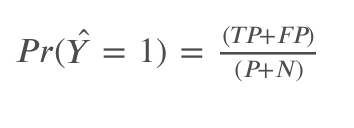
                                   

# Equalized Odds
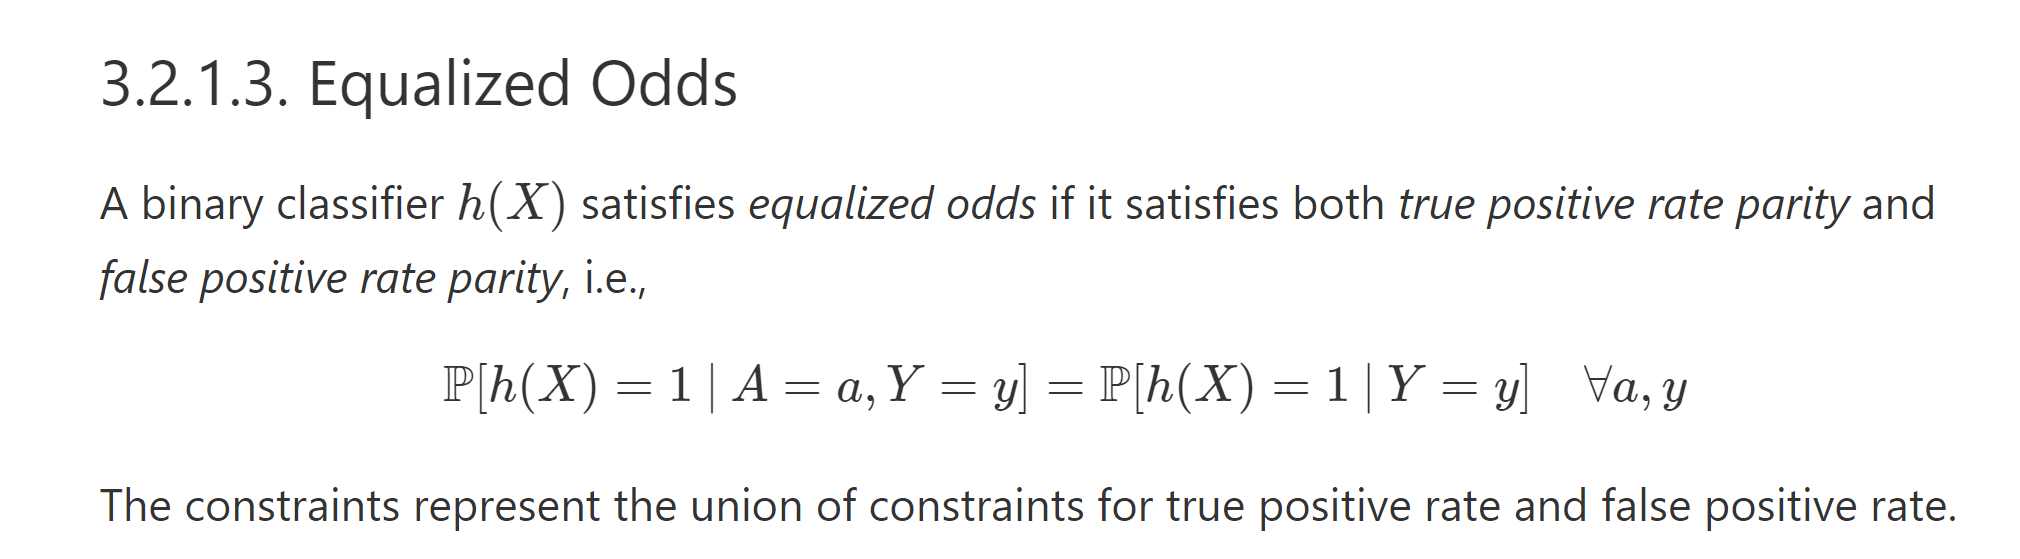

# This concept states that the model should:

1)correctly identify the positive outcome at equal rates across groups (same as in Equal Opportunity).

2)but also miss-classify the positive outcome at equal rates across groups (creating the same proportion of False Positives across groups)

Based on the confusion matrix, we require the True Positive Rate (TPR) and False Positive Rate (FPR) to be the same for each segment of the protected class.

True Positive Rate (A=0) = True Positive Rate (A=1) , and

False Positive Rate (A=0) = False Positive Rate (A=1)

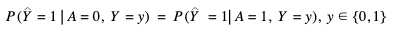

# When to use Equalised Odds
We should use Equalised Odds as a definition of fairness when:

1)There is a strong emphasis on predicting the positive outcome correctly (e.g.: correctly identifying who should get a loan drives profits)

2)We strongly care about minimising costly False Positives (e.g.: reducing the grant of loans to people who would not be able to pay back )

3)The target variable is not considered subjective (e.g.: labeling who is a ‘good’ employee is prompt to bias and hence very subjective)

4)The reward function of the model is not heavily compromised (e.g.: revenue or profit function for the business remains high)

In [2]:
# General imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fairlearn.reductions import TruePositiveRateParity
from fairlearn.metrics import true_positive_rate
import numpy as np
import pandas as pd
from collections import Counter
from fairlearn.metrics import (
    MetricFrame,
    false_positive_rate,
    true_positive_rate,
    selection_rate,
    count
)
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds


# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score


# UFRGS Entrance Exam and GPA Data
Entrance exam scores of students applying to a university in Brazil (Federal University of Rio Grande do Sul), along with the students' GPAs during the first three semesters at university. In this dataset, each row contains anonymized information about an applicant's scores on nine exams taken as part of the application process to the university, as well as their corresponding GPA during the first three semesters at university. The dataset has 43,303 rows, each corresponding to one student. The columns correspond to: 1) Gender. 0 denotes female and 1 denotes male. 2) Score on physics exam 3) Score on biology exam 4) Score on history exam 5) Score on second language exam 6) Score on geography exam 7) Score on literature exam 8) Score on Portuguese essay exam 9) Score on math exam 10) Score on chemistry exam 11) Mean GPA during first three semesters at university, on a 4.0 scale.

In [3]:
# Load the data
dataset = pd.read_csv('data_university.csv', names=["gender", "physics_score", "biology_score", "history_score","2nd_languege_score", "geography_score", "literature_score", "portuguese_score", "math_score", "chemistry_score", "GPA"])
raw_dataset = dataset
dataset.head()

,gender,physics_score,biology_score,history_score,2nd_languege_score,geography_score,literature_score,portuguese_score,math_score,chemistry_score,GPA
0,0,622.60,491.56,439.93,707.64,663.65,557.09,711.37,731.31,509.80,1.33333
1,1,538.00,490.58,406.59,529.05,532.28,447.23,527.58,379.14,488.64,2.98333
2,1,455.18,440.00,570.86,417.54,453.53,425.87,475.63,476.11,407.15,1.97333
3,0,756.91,679.62,531.28,583.63,534.42,521.40,592.41,783.76,588.26,2.53333
4,1,584.54,649.84,637.43,609.06,670.46,515.38,572.52,581.25,529.04,1.58667


In [4]:
print('train data shape:', dataset.shape)

train data shape: (43303, 11)


In [5]:
dataset['GPA'].unique()

array([1.33333 , 2.98333 , 1.97333 , ..., 0.42    , 0.92    , 0.783333])

In [6]:
# converting GPA in a 2 classes variable: 1:higher than 3 | 0: lower than 3
dataset['GPA'] = np.where(dataset['GPA'] >= 3, 1, 0)

In [7]:
dataset['gender'].value_counts()

1    22335
0    20968
Name: gender, dtype: int64

In [8]:
dataset['GPA'].value_counts()

0    23040
1    20263
Name: GPA, dtype: int64

In [9]:
dataset.columns

Index(['gender', 'physics_score', 'biology_score', 'history_score',
       '2nd_languege_score', 'geography_score', 'literature_score',
       'portuguese_score', 'math_score', 'chemistry_score', 'GPA'],
      dtype='object')

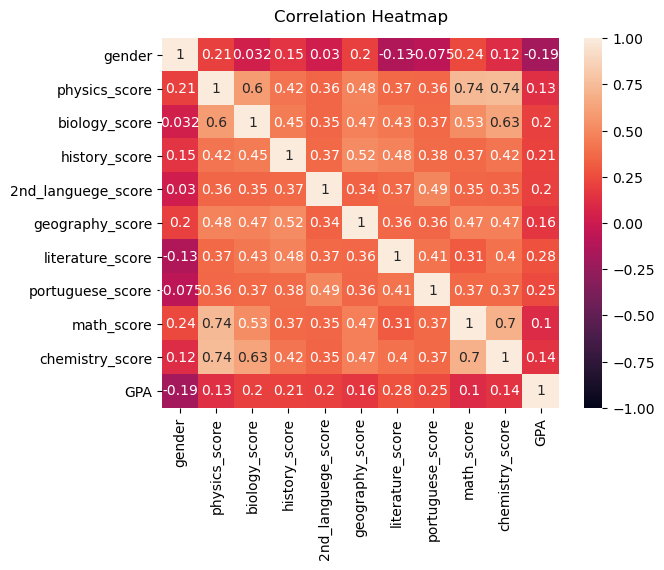

In [10]:
heatmap = sns.heatmap(raw_dataset.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [11]:
# Extract the sensitive feature
A = dataset["gender"]
A_str = A.map({ 0:"Female", 1:"Male"})
# Extract the target
Y = dataset["GPA"]

# Running the model without any implementation
Goal: to check if there is any correlation among the variables and to see the difference the two different kinds of errors (false positives and false negatives) on the test data.

In [12]:
# spliting into X and Y
X = dataset.drop(['GPA'], axis=1)
X_train, X_test, Y_train, Y_test, A_train, A_test, A_str_train, A_str_test = train_test_split(X, Y, A, A_str, 
    test_size=0.3, 
    random_state=12345,
    stratify=Y)
df_train = X_train
df_test = X_test

# Introduce a Synthetic Feature
We add a synthetic feature Final_Grade to make it highly predictive for the "female" group on purpose but not for the "male" group. Specifically, we set this up, so that a lower grade indicates that a female student is less likely to get Good grade, but provides no information on a male student.

In [13]:
dist_scale = 0.5
np.random.seed(12345) 
# Make 'Final_Grade' informative of the target
dataset['Final_Grade'] = Y + np.random.normal(scale=dist_scale, size=dataset.shape[0])
# But then make it uninformative for the male clients
dataset.loc[A==1, 'Final_Grade'] = np.random.normal(scale=dist_scale, size=dataset[A==1].shape[0])

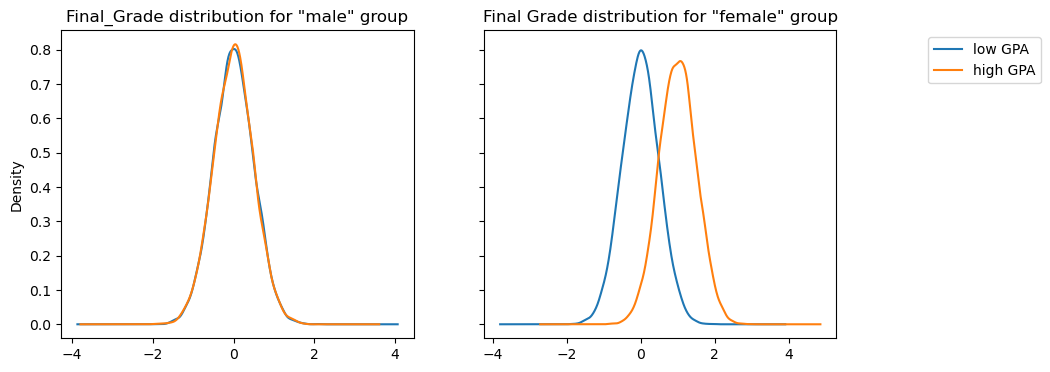

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
# Plot distribution of LIMIT_BAL for men
dataset['Final_Grade'][(A==1) & (Y==0)].plot(kind='kde', label="low GPA", ax=ax1, 
                                           title="Final_Grade distribution for \"male\" group")
dataset['Final_Grade'][(A==1) & (Y==1)].plot(kind='kde', label="high GPA", ax=ax1)
# Plot distribution of LIMIT_BAL for women
dataset['Final_Grade'][(A==0) & (Y==0)].plot(kind='kde', label="low GPA", ax=ax2, 
                                           legend=True, title="Final Grade distribution for \"female\" group")
dataset['Final_Grade'][(A==0) & (Y==1)].plot(kind='kde', label="high GPA", ax=ax2, 
                                           legend=True).legend(bbox_to_anchor=(1.6, 1))
plt.show()

In [15]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

In [16]:
model = lgb.LGBMClassifier(**lgb_params)
model.fit(df_train, Y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [17]:
# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

In [18]:
test_scores

array([0.33250176, 0.32797681, 0.58121235, ..., 0.69588573, 0.40761243,
       0.25656065])

In [19]:
# Train AUC
roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1])

0.7280874942437376

In [20]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

In [21]:
test_preds

array([0, 0, 1, ..., 1, 0, 0])

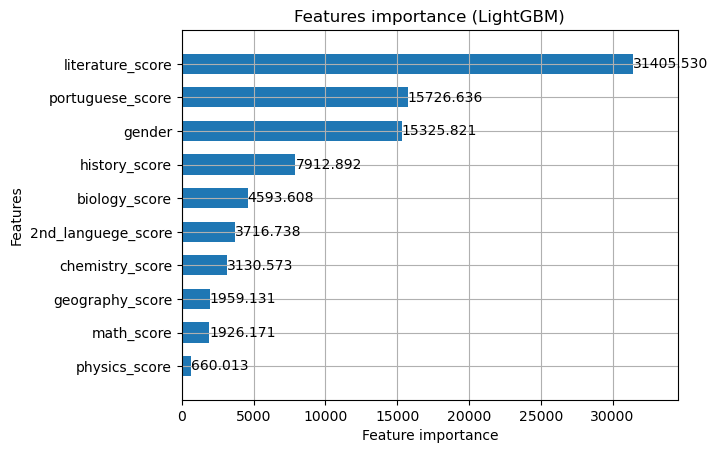

In [22]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=20) 
plt.show()

In [23]:
mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    Y_test, test_preds, sensitive_features=A_str_test)

mf.by_group

C:\Users\deepasaw\Anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "


,FPR,FNR
gender,,
Female,0.575128,0.222285
Male,0.12446,0.592739


In [24]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: 1-balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(balanced_accuracy_score, y_true, x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(roc_auc_score, y_true, x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())


In [26]:
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
metric_frame=get_metrics_df(models_dict, Y_test, A_str_test)
metric_frame


C:\Users\deepasaw\Anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "
C:\Users\deepasaw\Anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "


,Unmitigated
Overall selection rate,0.453006
Demographic parity difference,0.458005
Demographic parity ratio,0.335608
------,
Overall balanced error rate,0.339974
Balanced error rate difference,0.040107
------,
False positive rate difference,0.450667
False negative rate difference,0.370454
Equalized odds difference,0.450667


In [29]:
metric_frame[metric_frame['Unmitigated']!='']

,Unmitigated
Overall selection rate,0.453006
Demographic parity difference,0.458005
Demographic parity ratio,0.335608
Overall balanced error rate,0.339974
Balanced error rate difference,0.040107
False positive rate difference,0.450667
False negative rate difference,0.370454
Equalized odds difference,0.450667
Overall AUC,0.721969
AUC difference,0.030948


array([[<AxesSubplot:title={'center':'Unmitigated'}>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

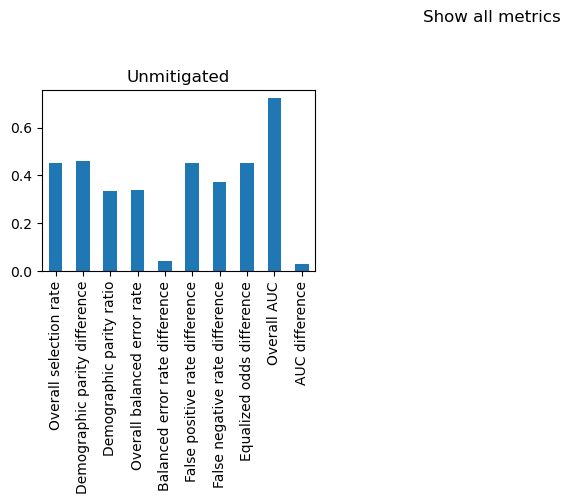

In [31]:
metric_frame[metric_frame['Unmitigated']!=''].plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

# Mitigating Equalized Odds Difference with Postprocessing
We attempt to mitigate the disparities in the lightgbm predictions using the Fairlearn postprocessing algorithm ThresholdOptimizer. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the lightgbm model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that ThresholdOptimizer is effectively optimizing balanced accuracy on the original data

In [32]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)
# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234).index)
df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]


In [33]:
pp_train_idx

Int64Index([    1,     2,     3,     6,     7,     8,    10,    11,    12,
               13,
            ...
            43291, 43292, 43294, 43295, 43296, 43297, 43298, 43300, 43301,
            43302],
           dtype='int64', length=28368)

In [34]:
postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

C:\Users\deepasaw\Anaconda3\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:270: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'),
                   prefit=True)

In [35]:
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

In [36]:
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
mitigatedmf=get_metrics_df(models_dict, Y_test, A_str_test)

C:\Users\deepasaw\Anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "
C:\Users\deepasaw\Anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "
C:\Users\deepasaw\Anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional argum

In [37]:
mitigatedmf


,Unmitigated,ThresholdOptimizer
Overall selection rate,0.453006,0.443923
Demographic parity difference,0.458005,0.032689
Demographic parity ratio,0.335608,0.929058
------,,
Overall balanced error rate,0.339974,0.403012
Balanced error rate difference,0.040107,0.013082
------,,
False positive rate difference,0.450667,0.008857
False negative rate difference,0.370454,0.017306
Equalized odds difference,0.450667,0.017306


array([[<AxesSubplot:title={'center':'Unmitigated'}>,
        <AxesSubplot:title={'center':'ThresholdOptimizer'}>,
        <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

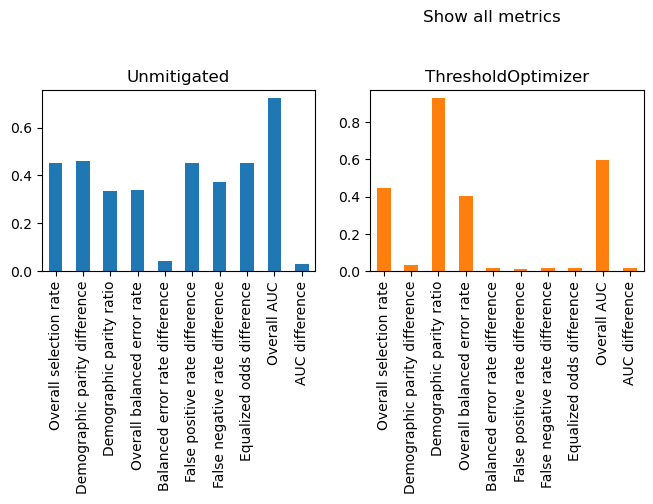

In [38]:
mitigatedmf[mitigatedmf['Unmitigated']!=''].plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

The ThresholdOptimizer algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, ThresholdOptimizer produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

# Mitigating Equalized Odds Difference with GridSearch
We now attempt to mitigate disparities using the GridSearch algorithm. Unlike ThresholdOptimizer, the predictors produced by GridSearch do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

In [34]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=50,
                   grid_limit=3)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

In [35]:
sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_] 

In [36]:
equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

In [37]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

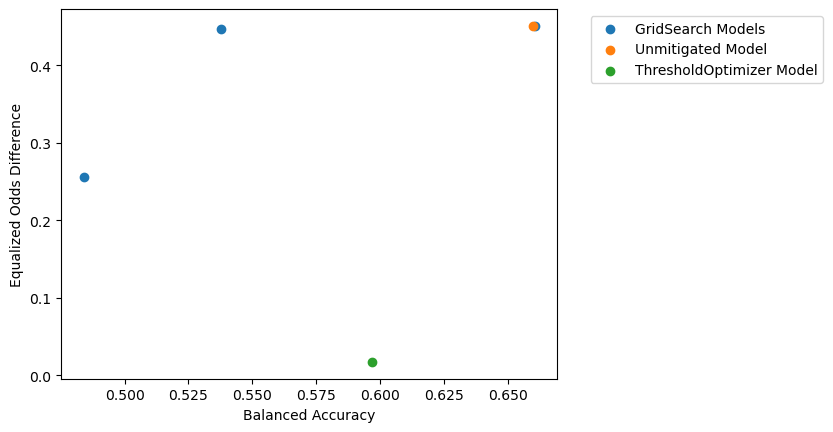

In [38]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

As intended, GridSearch models appear along the trade-off curve between the large balanced accuracy (but also large disparity), and low disparity (but worse balanced accuracy). This gives the data scientist a flexibility to select a model that fits the application context best.

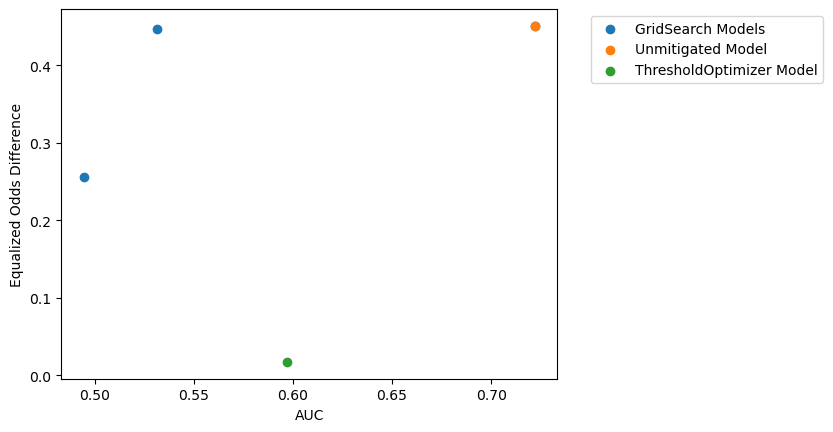

In [39]:
# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

In [40]:
# Compare GridSearch models with low values of equalized odds difference with the previously constructed models
grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                    for i in range(len(sweep_preds))
                    if non_dominated[i] and equalized_odds_sweep[i]<0.3}
models_dict.update(grid_search_dict)
get_metrics_df(models_dict, Y_test, A_str_test)

C:\Users\deepasaw\Anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "
C:\Users\deepasaw\Anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "
C:\Users\deepasaw\Anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional argum

,Unmitigated,ThresholdOptimizer,GridSearch_8
Overall selection rate,0.453006,0.443923,0.487106
Demographic parity difference,0.458005,0.032689,0.022327
Demographic parity ratio,0.335608,0.929058,0.955158
------,,,
Overall balanced error rate,0.339974,0.403012,0.515941
Balanced error rate difference,0.040107,0.013082,0.25333
------,,,
False positive rate difference,0.450667,0.008857,0.256041
False negative rate difference,0.370454,0.017306,0.250618
Equalized odds difference,0.450667,0.017306,0.256041


# Conclusion
In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed ThresholdOptimizer model and the GridSearch model. The ThresholdOptimizer greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the ThresholdOptimizer model were worse compared to the fairness-unaware model.

With the GridSearch algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.